In [1]:
import shutil
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import nibabel as nib
from tqdm import trange
import matplotlib.pyplot as plt

import visualization

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model = torch.hub.load('fepegar/highresnet', 'highres3dnet', pretrained=True)
# Strip layers after last dilation block
model = model.block[:-3]
model.to(device).eval();

Using cache found in /home/fernando/.cache/torch/hub/fepegar_highresnet_master


In [3]:
initial_size = 16
scale_factor = 1.2
iterations = 41
learning_rate = 1e-1
upsampling_steps = 9

upsample_step = nn.Upsample(scale_factor=scale_factor, mode='trilinear')

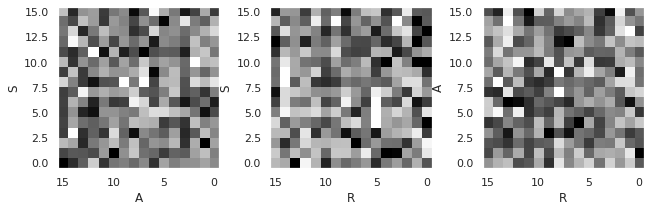

In [4]:
initial_shape = initial_size, initial_size, initial_size
means = torch.zeros(initial_shape)
stds = torch.ones(initial_shape)
input_volume = torch.normal(means, stds)
visualization.plot_volume(input_volume.numpy())
input_volume.unsqueeze_(0);  # add channels dim

In [5]:
model[-1].dilation_block[-1].residual_block[-1].convolutional_block[1]

ReLU()

In [6]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
last_residual_relu = model[-1].dilation_block[-1].residual_block[-1].convolutional_block[1]
hook = last_residual_relu.register_forward_hook(get_activation('last_relu'));

In [7]:
def tensor_to_nii(batch, upsample=None, path=None):
    batch = batch.clone().detach()
    if upsample is not None:
        batch = upsample(batch)
    array = batch.cpu().numpy().squeeze()
    nii = nib.Nifti1Image(array, np.eye(4))
    if path is not None:
        nii.to_filename(str(path))
    return nii

def final(ini, steps, factor):
    size = ini
    for _ in range(steps):
        size *= factor
        size = np.floor(size)
    return 3 * (int(size),)

output_size = final(initial_size, upsampling_steps, scale_factor)
upsample_final = nn.Upsample(size=output_size, mode='trilinear')

In [8]:
output_dir = Path('/tmp/vis')
if output_dir.is_dir():
    import shutil
    shutil.rmtree(output_dir)
output_dir.mkdir(exist_ok=True)

feature_index = 16

for feature_index in trange(64):
    batch = input_volume.unsqueeze(0).to(device)

    losses = []
    for step in range(1 + upsampling_steps):
#         print('Size:',batch.shape[-1])
        batch = batch.clone().detach().requires_grad_(True)  # recommended by PyTorch
        optimizer = optim.Adam([batch], lr=learning_rate, weight_decay=1e-6)
        for i in range(iterations):
            optimizer.zero_grad()
            model(batch)
            loss = -activation['last_relu'][0, feature_index, ...].mean()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
    #         if i % 10 == 0:
    #             path = output_dir / f'step_{step}_iter_{i:04d}.nii.gz'
    #             tensor_to_nii(batch, upsample=upsample_final, path=path)
        batch = batch.detach().clone()
        batch = upsample_step(batch)

    path = output_dir / f'feature_{feature_index}.nii.gz'
    tensor_to_nii(batch, upsample=None, path=path)

    #     iterations *= .85
    #     iterations = np.round(iterations).astype(int)


  0%|          | 0/64 [00:00<?, ?it/s]

Size: 16


/home/fernando/miniconda3/envs/nn/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


  2%|▏         | 1/64 [04:35<4:49:35, 275.81s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


  3%|▎         | 2/64 [09:15<4:46:04, 276.84s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


  5%|▍         | 3/64 [13:56<4:42:43, 278.09s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


  6%|▋         | 4/64 [18:39<4:39:48, 279.80s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


  8%|▊         | 5/64 [23:24<4:36:29, 281.18s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


  9%|▉         | 6/64 [28:09<4:33:04, 282.50s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


 11%|█         | 7/64 [33:00<4:30:33, 284.80s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


 12%|█▎        | 8/64 [37:47<4:26:39, 285.71s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


 14%|█▍        | 9/64 [42:36<4:22:35, 286.47s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


 16%|█▌        | 10/64 [47:23<4:18:08, 286.82s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44
Size: 52
Size: 62
Size: 74


 17%|█▋        | 11/64 [52:12<4:13:50, 287.36s/it]

Size: 16
Size: 19
Size: 22
Size: 26
Size: 31
Size: 37
Size: 44


KeyboardInterrupt: 